# Ingredient Detection
**Azure Custom Vision**

The following notebook contains the code for building an ingredient detection model using Azure Custom Vision.

## Table of Contents
- [Imort Modules](#import-modules)
- [Set-up](#set-up)
    - [Create a Custom Vision Resource](#create-a-custom-vision-resource)
    - [Configure Parameters](#configure-parameters)
    - [Copy Subscription Key and Endpoint](#copy-subscription-key-and-endpoint)
    - [Authenticate with Custom Vision Client](#authenticate-with-custom-vision-client)
- [Model Building](#model-building)
    - [Data Preparation](#data-preparation)
    - [Upload Labels to Custom Vision Project](#upload-labels-to-custom-vision-project)
    - [Train Model](#train-model)
    - [Publish the Trained Model](#publish-the-trained-model)

---

# Import Modules <a class="anchor" id="import-modules"></a>

In [91]:
# These modules are used to interact with the operating system and perform basic tasks
import os
import glob
import io
import time

# These modules are used for applying operations onto large and vectorised data
import numpy as np
import pandas as pd

# Azure Cognitive Services SDK for Custom Vision, used to interact with the Custom Vision Service
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import (
    ImageFileCreateBatch,
    ImageFileCreateEntry,
    Region
)
from msrest.authentication import ApiKeyCredentials

from PIL import Image, ImageDraw, ImageFont

# Config including the Endpoints and Subscription keys to the Custom Vision Service
import config

# Set-up <a class="anchor" id="set-up"></a>

## Authenticate with Custom Vision Client <a class="anchor" id="authenticate-with-custom-vision-client"></a>

The below code is used to create the training and prediction clients for interacting with the respective components of the Azure Custom Vision service.

- **trainer**: Used to make API calls required for training a Custom Vision model such as uploading training images, start a training job, and publishing a model
- **predictor**: Used to send images for predictions once the model has been trained and published


In [2]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": config.KEY})
trainer = CustomVisionTrainingClient(config.ENDPOINT, training_credentials)

prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": config.KEY})
predictor = CustomVisionPredictionClient(config.ENDPOINT, prediction_credentials)

# Model Building <a class="anchor" id="model-building"></a>

## Data Preparation <a class="anchor" id="data-preparation"></a>

The following code downloads an image dataset and prepares it to be sent to the Azure Custom Vision Service.

The data is sourced from [RoboFlow Vehicles-OpenImages](https://public.roboflow.com/object-detection/vehicles-openimages). It is available for use under the creative commons licence.

The dataset contains images of cars, buses, motorcycles, trucks, and ambulances all labelled with tags and bounding boxes using the [YOLOv8 Format](https://roboflow.com/formats/yolov8-pytorch-txt).

The image metadata has been loaded into a Pandas DataFrame and manipulated into the correct format for the Azure Custom Vision service.

In [3]:
os.makedirs("./data/",exist_ok=True)

In [5]:
# Download the dataset from the public website
!curl -L "https://universe.roboflow.com/ds/qdAMAf1weR?key=3n1WMDqhcs" > roboflow.zip; unzip roboflow.zip -d './data'; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   1154      0 --:--:-- --:--:-- --:--:--  1158
100 79.6M  100 79.6M    0     0  7209k      0  0:00:11  0:00:11 --:--:-- 9589k
Archive:  roboflow.zip
 extracting: ./data/README.dataset.txt  
 extracting: ./data/README.roboflow.txt  
 extracting: ./data/data.yaml        
   creating: ./data/test/
   creating: ./data/test/images/
 extracting: ./data/test/images/105_jpg.rf.7547e05073fd8f1776974dcca8f2b25e.jpg  
 extracting: ./data/test/images/1075_jpg.rf.c4684d24e4ffc1ada05065cc6fdccb13.jpg  
 extracting: ./data/test/images/107_jpg.rf.f747fb1a5dda90837303151d319f1560.jpg  
 extracting: ./data/test/images/10_jpg.rf.d2e67b2a31285a9747e0567cfcf5ec5a.jpg  
 extracting: ./data/test/images/110_jpg.rf.06921b4020eab1ba65ab35455a5f3d66.jpg  
 extracting: ./data/test/images/111_jpg.rf.b628fc9283a622f4ecae73b6eaef

Loop through every label TXT file and extract class index label, and bounding box coordinates. Then, derive the corresponding image file path from the label path.

Collect all into one DataFrame ready for manipulation

In [6]:
data_directory = "./data"

labels_df_list = []
for filepath in glob.glob(f"{data_directory}/*/labels/*"):
    df = pd.read_csv(filepath,sep=" ", names=["class","center_x","center_y","width","height"])
    df["file_path"] = filepath.replace("labels","images")[:-4]+'.jpg'
    labels_df_list.append(df)

# Concatenate all files into one DataFrame
labels_df = pd.concat(labels_df_list)

In [13]:
len(labels_df["class"].unique())

38

Perform transformations on the given labels so they are in the format expected for Azure Customer Vision (outlined below):
- Tag name
- Left coordinate of bounding box
- top coordinate of bounding box
- width of bounding box
- height of bounding box

In [14]:
# Create a map from tag index to tag name
classes = ['other', 'almond', 'apple', 'avocado', 'beef', 'bell pepper', 'blueberry', 'bread', 'broccoli', 'butter', 'carrot', 'cheese', 'chilli', 'cookie', 'corn', 'cucumber', 'egg', 'eggplant', 'garlic', 'lemon', 'milk', 'mozarella cheese', 'mushroom', 'mussel', 'onion', 'oyster', 'parmesan cheese', 'pasta', 'pork rib', 'potato', 'salmon', 'scallop', 'shrimp', 'strawberry', 'toast bread', 'tomato', 'tuna', 'yogurt']
class_map = {idx: class_name for idx, class_name in enumerate(classes)}

labels_df["tag"] = labels_df["class"].replace(class_map)
# Calculate left and top coordinate of bounding box
labels_df["left"] = (labels_df["center_x"]-labels_df["width"]/2).clip(lower=0)
labels_df["top"] = (labels_df["center_y"]-labels_df["height"]/2).clip(lower=0)

labels_df_reset = labels_df.reset_index()

In [79]:
# Filter the labels to exclude other
labels_df_column_filtered = labels_df_reset.loc[
    labels_df_reset["tag"]!="other"
    ]


## Create a Custom Vision Project <a class="anchor" id="create-a-custom-vision-project"></a>

In [33]:
project_name = "Ingredient Detection"

# Find the object detection domain, in this case use "General"
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General [A1]")

# Find the existing projects, if one does not exist with the name then create it
existing_projects = {}
for project in trainer.get_projects():
    print(f"Name: {project.name}, ID: {project.id}")
    existing_projects[project_name] = project.id

if existing_projects.get(project_name):
    print("Project with that name already exists...")
    project = trainer.get_project(existing_projects[project_name])
else:
    # Create a new project
    print ("Creating project...")
    project = trainer.create_project(project_name, domain_id=obj_detection_domain.id)

Name: Ingredient Detection, ID: 891232d0-5cda-4a76-adcb-ce15dd53b584
Project with that name already exists...


In [37]:
# Add tags to the project
tag_almond = trainer.create_tag(project.id, 'almond')
time.sleep(1)
tag_apple = trainer.create_tag(project.id, 'apple')
time.sleep(1)
tag_avocado = trainer.create_tag(project.id, 'avocado')
time.sleep(1)
tag_beef = trainer.create_tag(project.id, 'beef')
time.sleep(1)
tag_bell_pepper = trainer.create_tag(project.id, 'bell pepper')
time.sleep(1)
tag_blueberry = trainer.create_tag(project.id, 'blueberry')
time.sleep(1)
tag_bread = trainer.create_tag(project.id, 'bread')
time.sleep(1)
tag_broccoli = trainer.create_tag(project.id, 'broccoli')
time.sleep(1)
tag_butter = trainer.create_tag(project.id, 'butter')
time.sleep(1)
tag_carrot = trainer.create_tag(project.id, 'carrot')
time.sleep(1)
tag_cheese = trainer.create_tag(project.id, 'cheese')
time.sleep(1)
tag_chilli = trainer.create_tag(project.id, 'chilli')
time.sleep(1)
tag_cookie = trainer.create_tag(project.id, 'cookie')
time.sleep(1)
tag_corn = trainer.create_tag(project.id, 'corn')
time.sleep(1)
tag_cucumber = trainer.create_tag(project.id, 'cucumber')
time.sleep(1)
tag_egg = trainer.create_tag(project.id, 'egg')
time.sleep(1)
tag_eggplant = trainer.create_tag(project.id, 'eggplant')
time.sleep(1)
tag_garlic = trainer.create_tag(project.id, 'garlic')
time.sleep(1)
tag_lemon = trainer.create_tag(project.id, 'lemon')
time.sleep(1)
tag_milk = trainer.create_tag(project.id, 'milk')
time.sleep(1)
tag_mozarella_cheese = trainer.create_tag(project.id, 'mozarella cheese')
time.sleep(1)
tag_mushroom = trainer.create_tag(project.id, 'mushroom')
time.sleep(1)
tag_mussel = trainer.create_tag(project.id, 'mussel')
time.sleep(1)
tag_onion = trainer.create_tag(project.id, 'onion')
time.sleep(1)
tag_oyster = trainer.create_tag(project.id, 'oyster')
time.sleep(1)
tag_parmesan_cheese = trainer.create_tag(project.id, 'parmesan cheese')
time.sleep(1)
tag_pasta = trainer.create_tag(project.id, 'pasta')
time.sleep(1)
tag_pork_rib = trainer.create_tag(project.id, 'pork rib')
time.sleep(1)
tag_potato = trainer.create_tag(project.id, 'potato')
time.sleep(1)
tag_salmon = trainer.create_tag(project.id, 'salmon')
time.sleep(1)
tag_scallop = trainer.create_tag(project.id, 'scallop')
time.sleep(1)
tag_shrimp = trainer.create_tag(project.id, 'shrimp')
time.sleep(1)
tag_strawberry = trainer.create_tag(project.id, 'strawberry')
time.sleep(1)
tag_toast_bread = trainer.create_tag(project.id, 'toast bread')
time.sleep(1)
tag_tomato = trainer.create_tag(project.id, 'tomato')
time.sleep(1)
tag_tuna = trainer.create_tag(project.id, 'tuna')
time.sleep(1)
tag_yogurt = trainer.create_tag(project.id, 'yogurt')

## Upload Labels to Custom Vision Project <a class="anchor" id="upload-labels-to-custom-vision-project"></a>

In [76]:
# Map tag name to tag ID in the Azure Custom Vision project
tag_map = {tag : globals()[f"tag_{tag.replace(' ','_')}"].id for tag in classes if tag != "other"}

Firstly, group the Pandas DataFrame containing the metadata for images by the filename to ensure uploading one unique file.

Next, generate the bounding box regions for each row in the group, which correspond to an object in the given image.

Then, create the ImageFileCreateEntry object, which contains the binary image data and regions and append to the full list of images to be uploaded.

Finally, batch the list of images to be uploaded into groups of 64, as this is the largest amount that can be uploaded at once, and upload to images with regions the the Azure Custom Vision Service


In [77]:
tagged_images_with_regions = []
# Loop through each file in the metadata DataFrame
for file_path, rows in labels_df_filtered.groupby("file_path"):
    # Create regions from metadata rows
    regions = [ Region(
        tag_id=tag_map[row["tag"]],
        left=row["left"],
        top=row["top"],
        width=row["width"],
        height=row["height"]
        ) for _, row in rows.iterrows() ]
    # Open the image file as bytes
    with open(file_path, mode="rb") as image_contents:
        # Append the image contents and region to the list of images to be uploaded
        tagged_images_with_regions.append(
            ImageFileCreateEntry(
                name=file_path.rsplit('/', 1)[1],
                contents=image_contents.read(),
                regions=regions
                )
            )

#Find out how many (k) batches of 64 the list can be divided into
k, m = divmod(len(tagged_images_with_regions), 64)
image_tags = []
for i in range(k):
    # Upload the 64 images to the Azure Custom Vision service
    upload_result = trainer.create_images_from_files(
        project.id,
        ImageFileCreateBatch(images=tagged_images_with_regions[64*i:64*(i+1)])
    )

In [85]:
# Upload the rest of the images to the Azure Custom Vision service
upload_result = trainer.create_images_from_files(
    project.id,
    ImageFileCreateBatch(images=tagged_images_with_regions[-m:])
)

## Train Model <a class="anchor" id="train-model"></a>

In [86]:
try:
    # Submit the training job
    iteration = trainer.train_project(project.id)
    while (iteration.status != "Completed"):
        # Get status of training every minute
        iteration = trainer.get_iteration(project.id, iteration.id)
        print ("Training status: " + iteration.status)
        time.sleep(60)
except:
    # If the training fails (for example, nothing has changed) get the latest iteration
    print("Training Failed, getting latest iteration")
    iteration = trainer.get_iterations(project.id)[0]

Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training sta

## Publish the Trained Model <a class="anchor" id="publish-the-trained-model"></a>

In [87]:
publish_iteration_name = "IngredientDetectorModel"

In [88]:
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, config.RESOURCE_ID)

True

## Test the model with a sample image <a class="anchor" id="test-the-model-with-a-sample-image"></a>

	butter: 81.47%                 bbox.left = 0.07,                 bbox.top = 0.19,                 bbox.width = 0.47,                 bbox.height = 0.53
	cheese: 38.76%                 bbox.left = 0.09,                 bbox.top = 0.17,                 bbox.width = 0.48,                 bbox.height = 0.54
	cheese: 27.85%                 bbox.left = 0.04,                 bbox.top = 0.13,                 bbox.width = 0.58,                 bbox.height = 0.87
	milk: 44.21%                 bbox.left = 0.10,                 bbox.top = 0.14,                 bbox.width = 0.58,                 bbox.height = 0.60


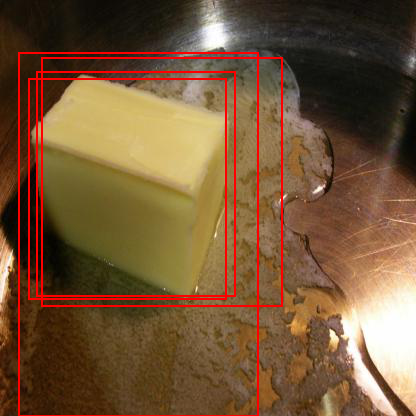

In [92]:
# Test the model with a sample image

# Now there is a trained endpoint that can be used to make a prediction

# Open the sample image and get back the prediction results.
test_image_url = os.path.join (data_directory,
                               "test",
                               "images",
                               "2_jpg.rf.5d25c76af4cc94f25770cbe2cb1a88fb.jpg"
                            )
with open(test_image_url, mode="rb") as test_data:
    results = predictor.detect_image(project.id, publish_iteration_name, test_data)
 
# Plot the results
# Load the original image
image = Image.open(test_image_url)
# Create a layer to draw on top of the image
image_draw = ImageDraw.Draw(image)
for prediction in results.predictions:
    if prediction.probability>0.25:
        # Print the prediction details
        print("\t" + prediction.tag_name +
            f": {prediction.probability * 100:.2f}% \
                bbox.left = {prediction.bounding_box.left:.2f}, \
                bbox.top = {prediction.bounding_box.top:.2f}, \
                bbox.width = {prediction.bounding_box.width:.2f}, \
                bbox.height = {prediction.bounding_box.height:.2f}")
        # Draw the bounding box
        rectangle = [416*prediction.bounding_box.left,
                     416*prediction.bounding_box.top,
                     416*(prediction.bounding_box.left+prediction.bounding_box.width),
                     416*(prediction.bounding_box.top+prediction.bounding_box.height)]
        image_draw.rectangle(rectangle, outline="Red", width=2)

display(image)